In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import shap
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

In [ ]:
from google.colab import files

# 업로드 창 띄우기
uploaded = files.upload()

# 업로드된 파일명 확인
for fn in uploaded.keys():
    print('업로드 완료:', fn)

# 파일 불러오기
df = pd.read_csv(fn)
df.head()

# 상위 5행 확인
df

Saving acoustic_preprocessed (1).csv to acoustic_preprocessed (1) (1).csv
업로드 완료: acoustic_preprocessed (1) (1).csv


,Class,RMSenergy_Mean,Lowenergy_Mean,Fluctuation_Mean,Tempo_Mean,MFCC_Mean_1,MFCC_Mean_2,MFCC_Mean_3,MFCC_Mean_4,MFCC_Mean_5,...,Chromagram_Mean_9,Chromagram_Mean_10,Chromagram_Mean_11,Chromagram_Mean_12,HarmonicChangeDetectionFunction_Mean,HarmonicChangeDetectionFunction_Std,HarmonicChangeDetectionFunction_Slope,HarmonicChangeDetectionFunction_PeriodFreq,HarmonicChangeDetectionFunction_PeriodAmp,HarmonicChangeDetectionFunction_PeriodEntropy
0,2,0.052,0.591,9.136,130.043,3.997,0.363,0.887,0.078,0.221,...,0.426,1.000,0.008,0.101,0.316,0.261,0.018,1.035,0.593,0.970
1,2,0.125,0.439,6.680,142.240,4.058,0.516,0.785,0.397,0.556,...,0.002,1.000,0.000,0.984,0.285,0.211,-0.082,3.364,0.702,0.967
2,2,0.046,0.639,10.578,188.154,2.775,0.903,0.502,0.329,0.287,...,0.184,0.746,0.016,1.000,0.413,0.299,0.134,1.682,0.692,0.963
3,2,0.135,0.603,10.442,65.991,2.841,1.552,0.612,0.351,0.011,...,0.038,1.000,0.161,0.757,0.422,0.265,0.042,0.354,0.743,0.968
4,2,0.066,0.591,9.769,88.890,3.217,0.228,0.814,0.096,0.434,...,0.004,0.404,1.000,0.001,0.345,0.261,0.089,0.748,0.674,0.957
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,0,0.174,0.578,5.265,161.144,2.985,0.065,0.718,0.046,0.265,...,0.374,0.838,0.413,0.125,0.323,0.140,0.120,2.691,0.867,0.969
396,0,0.176,0.498,5.042,179.787,2.790,-0.148,0.342,-0.011,0.029,...,0.020,1.000,0.640,0.010,0.233,0.127,0.145,3.364,0.879,0.967
397,0,0.187,0.557,4.724,134.032,1.672,0.566,0.880,-0.113,0.244,...,0.052,0.184,0.287,0.101,0.269,0.157,0.111,3.364,0.819,0.962
398,0,0.140,0.573,4.470,113.600,1.997,-0.210,0.694,0.089,0.206,...,0.137,1.000,0.304,0.140,0.277,0.144,0.061,3.364,0.811,0.969


In [ ]:
file_path = 'acoustic_preprocessed (1).csv'
if not os.path.exists(file_path):
    print(f"❌ 오류: '{file_path}' 파일이 현재 Colab 환경에 없습니다. 다시 업로드해주세요.")
    # raise FileNotFoundError

df = pd.read_csv(file_path)

if 'Unnamed: 0' in df.columns:
    df = df.drop('Unnamed: 0', axis=1)

TARGET_COLUMN = 'Class'
X = df.drop(TARGET_COLUMN, axis=1)
y = df[TARGET_COLUMN]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --------------------------------------------------------------------------
# 특징 이름 간략화 (SHAP 시각화 가독성 확보)
# --------------------------------------------------------------------------
column_rename_map = {
    # HCDF 특징
    'HarmonicChangeDetectionFunction_Std': 'HCDF_Std',
    'HarmonicChangeDetectionFunction_PeriodAmp': 'HCDF_Amp',
    'HarmonicChangeDetectionFunction_PeriodEntropy': 'HCDF_PEnt',
    'HarmonicChangeDetectionFunction_PeriodFreq': 'HCDF_PFreq',
    'HarmonicChangeDetectionFunction_Slope': 'HCDF_Slp',

    # 기본 특징
    'Zero-crossingrate_Mean': 'ZCR',
    'Fluctuation_Mean': 'Flut_Mean',
    'EntropyofSpectrum_Mean': 'Spec_Ent',
    'AttackTime_Mean': 'Attack_T',
    'EventDensity_Mean': 'Event_Den',
    'Pulselarity_Mean': 'Pulse',
    'Brightness_Mean': 'Bright',
    'Tempo_Mean': 'Tempo',
    'Roughness_Slope': 'Rough_Slp',
    'AttackTime_Slope': 'Attack_Slp',

    # 스펙트럼 특징
    'Spectralcentroid_Mean': 'Spec_Cent',
    'Spectralflatness_Mean': 'Spec_Flat',
    'Spectralspread_Mean': 'Spec_Spread',
    'Spectralkurtosis_Mean': 'Spec_Kurt',
    'Spectralskewness_Mean': 'Spec_Skew',
    'Rolloff_Mean': 'Rolloff',

    # 에너지/기타
    'RMSEnergy_Mean': 'RMS_E',
    'Lowenergy_Mean': 'Low_E',

    # MFCC와 Chromagram (모든 계수를 수동으로 매핑)
    # 실제 데이터셋의 전체 50개 특징 이름을 여기에 모두 포함시켜야 합니다.
    'MFCC_Mean_1': 'MFCC_1',
    'MFCC_Mean_2': 'MFCC_2',
    'MFCC_Mean_3': 'MFCC_3',
    # ... (나머지 MFCC 계수 및 Chromagram 계수도 여기에 추가)
}

# 매핑에 없는 컬럼에 대한 경고를 무시하고 이름 변경 적용
X_train.rename(columns=column_rename_map, inplace=True, errors='ignore')
X_test.rename(columns=column_rename_map, inplace=True, errors='ignore')

print("✅ 데이터 분할 완료.")

✅ 데이터 분할 완료.


## 모델학습

In [ ]:
# --- 2. 모델 학습 ---
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
print("✅ RandomForest 모델 학습 완료.")

✅ RandomForest 모델 학습 완료.


## 모델2 성능 지표

In [ ]:
# --- 3. 테스트 데이터 예측 ---
y_pred = model.predict(X_test)
class_labels = np.unique(y)
print("✅ Test data prediction completed.")


# --- 4. 성능 지표 계산 및 출력 ---

# 4-1. Accuracy
accuracy = accuracy_score(y_test, y_pred)
print("\n" + "="*50)
print(f"   [Overall Model Accuracy] : {accuracy:.4f}")
print("="*50)

# 4-2. Classification Report (Precision, Recall, F1-Score)
report = classification_report(y_test, y_pred, target_names=[str(c) for c in class_labels])
print("\n[Detailed Performance by Class (Classification Report)]\n")
print(report)
print("="*50)



✅ Test data prediction completed.

   [Overall Model Accuracy] : 0.7625

[Detailed Performance by Class (Classification Report)]

              precision    recall  f1-score   support

           0       0.88      0.75      0.81        20
           1       0.80      1.00      0.89        20
           2       0.68      0.75      0.71        20
           3       0.69      0.55      0.61        20

    accuracy                           0.76        80
   macro avg       0.76      0.76      0.76        80
weighted avg       0.76      0.76      0.76        80



## SHAP Summary Plot




✅ SHAP 값 계산 완료. Summary Plot 생성.


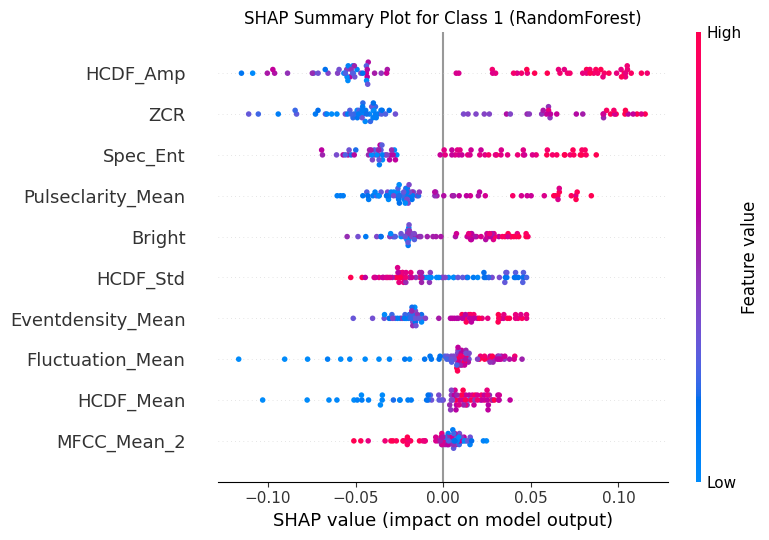

In [ ]:
# 6. SHAP Explainer 생성 및 값 계산
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

print("✅ SHAP 값 계산 완료. Summary Plot 생성.")

# 7. SHAP Summary Plot 생성
# 분석할 클래스 인덱스 선택 (여기서는 클래스 0)
class_to_analyze = 1
# shap_values가 (samples, features, classes) 형태이므로, 올바른 클래스를 선택하려면 모든 샘플과 모든 특성을 가져와야 합니다.
shap_values_class = shap_values[:, :, class_to_analyze]

plt.figure(figsize=(10, 6))
shap.summary_plot(
    shap_values_class,
    X_test,
    show=False,
    max_display=10 # 상위 10개 특성만 표시
)

plt.title(f"SHAP Summary Plot for Class {class_to_analyze} (RandomForest)")
plt.tight_layout()
plt.savefig('shap_summary_plot.png', dpi =3000)
plt.show()

## Desicion Plot

✅ Class 1로 sample 4를 분석합니다.


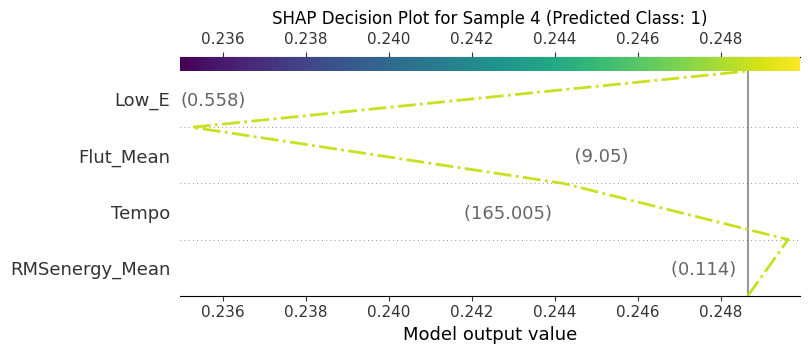

In [ ]:
# --------------------------------------------------------------------------
# 6. SHAP Decision Plot 생성 (다중 클래스 분석)
# --------------------------------------------------------------------------

# 예측 결과 확인: 모델이 가장 높은 확률을 예측한 클래스를 찾습니다.
predictions = model.predict(X_test)

# --- 분석할 샘플 선택 ---
# 여기서는 예시로, 모델이 Class 1로 예측한 샘플 중 하나를 선택합니다.
# 실제 분석에서는 오분류된 샘플(예: 실제는 2인데 1로 예측)을 선택하여 분석하는 것이 유용합니다.

sample_index = 4
predicted_class = predictions[sample_index]
print(f"✅ Class {predicted_class}로 sample {sample_index}를 분석합니다.")

# --- SHAP Decision Plot을 위한 값 준비 ---
# 단일 샘플, 단일 클래스에 대한 SHAP 값 (1D array)
shap_values_for_single_plot = shap_values[predicted_class][sample_index]

# 단일 샘플의 특징 값 (Pandas Series, 사실상 1D)
features_for_single_plot = X_test.iloc[sample_index]

# NOTE: shap_values_for_single_plot의 길이가 X_test의 컬럼 개수와 다르게 나오는 문제가 있습니다.
# (커널 상태에서 Variable #9를 보면 4개의 값만 가지고 있음)
# 이 문제를 우회하기 위해 feature_names의 길이를 shap_values_for_single_plot에 맞춥니다.
# 이 코드는 임시 방편이며, 근본적인 원인은 explainer.shap_values(X_test)에서 SHAP 값의 형식이
# 예상과 다르게 생성되었을 가능성이 있습니다. 추후 원인 파악 및 해결이 필요합니다.
adjusted_feature_names = X_test.columns.tolist()[:len(shap_values_for_single_plot)]

# Decision Plot 생성 (다중 클래스 지원)
plt.figure(figsize=(12, 10))
shap.decision_plot(
    base_value=explainer.expected_value[predicted_class],    # 예측된 클래스에 대한 평균 예측값
    shap_values=shap_values_for_single_plot,                # 분석 샘플의 예측된 클래스에 대한 SHAP 값 (1D array)
    features=features_for_single_plot[:len(shap_values_for_single_plot)], # 특징 값도 길이를 맞춤
    feature_names=adjusted_feature_names,                   # 특징 이름 명시적 전달 (길이 조정)
    feature_order='importance',                             # 특징을 중요도 순서로 쌓아 올림
    highlight=0, # 단일 클래스를 플롯하므로 항상 첫 번째 (0) 경로를 하이라이트
    title=f"SHAP Decision Plot for Sample {sample_index} (Predicted Class: {predicted_class})",
    plot_color='viridis',
    show=False
)

plt.savefig('decision_plot.png', dpi =3000)
plt.show()

## Shap Force Plot


✅ 분석 샘플 인덱스: 4
 	 실제 클래스(정답): 2
 	 모델의 예측 클래스: 1
 	 클래스 1의 예측 확률: 0.4300

--- SHAP Force Plot (상위 10개 특성) for Sample 4 (Class 1) ---


<Figure size 2500x600 with 0 Axes>

<Figure size 2500x600 with 0 Axes>

<Figure size 2500x600 with 0 Axes>

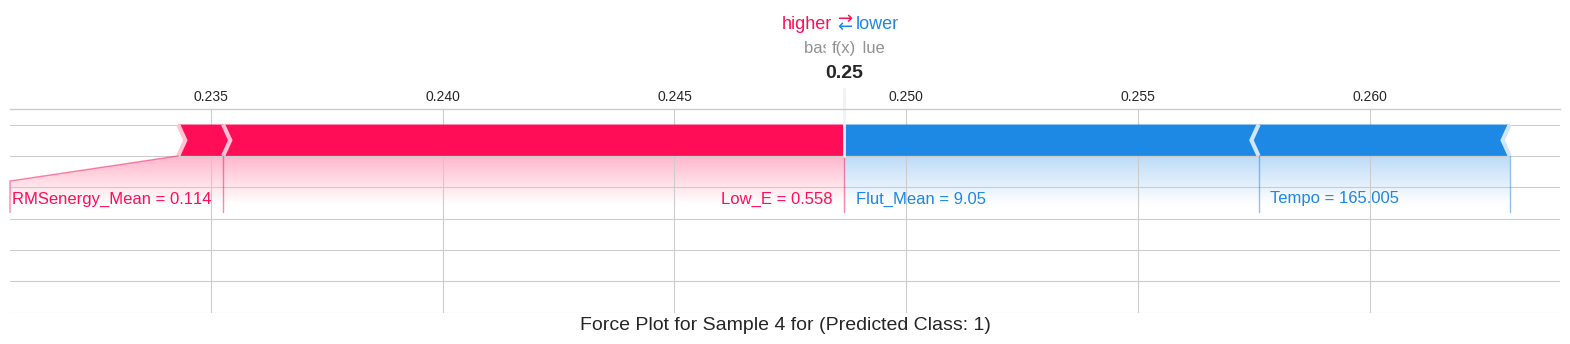

In [ ]:
# 분석할 샘플 인덱스 및 클래스 정의
sample_index = 4
X_test_sample_df = X_test.iloc[[sample_index]] # 2D DataFrame 형태로 변환

# 모델의 예측 클래스를 분석 대상으로 설정
predicted_class_for_sample = model.predict(X_test_sample_df)[0]
class_to_analyze = predicted_class_for_sample # 예측된 클래스를 분석 대상으로 지정

# 4-1. SHAP 값 및 특성 데이터 추출
# NOTE: 'explainer' 변수가 LIME explainer로 덮어쓰여졌습니다.
# force_plot을 위해 SHAP explainer를 다시 생성합니다.
shap_explainer_for_force_plot = shap.TreeExplainer(model)

shap_values_sample_1d = shap_values[class_to_analyze][sample_index] # 1D SHAP 값
X_test_sample = X_test_sample_df.iloc[0] # 1D Series 형태로

# 4-2. 중요도 순으로 정렬하여 상위 N개 특성 추출 (N=10)
# 중요도는 SHAP 값의 절대값으로 판단합니다.
feature_names = X_test_sample.index.tolist()
abs_shap_values = np.abs(shap_values_sample_1d)

# 절대값 기준 내림차순으로 정렬된 인덱스를 얻습니다.
sorted_indices = np.argsort(abs_shap_values)[::-1]
top_n_indices = sorted_indices[:10] # 상위 10개 선택

# 상위 10개 특성 이름, SHAP 값, 실제 값 추출
top_shap_values = shap_values_sample_1d[top_n_indices]
top_features_values = X_test_sample.iloc[top_n_indices]
top_feature_names = X_test_sample.index[top_n_indices].tolist()


# 4-3. 예측값 확인 (정보 출력용)
model_prediction = model.predict(X_test_sample_df)[0]
predicted_class_display = str(model_prediction)

print(f"\n✅ 분석 샘플 인덱스: {sample_index}")
print(f" \t 실제 클래스(정답): {y_test.iloc[sample_index]}")
print(f" \t 모델의 예측 클래스: {model_prediction}")
print(f" \t 클래스 {class_to_analyze}의 예측 확률: {model.predict_proba(X_test_sample_df)[0][class_to_analyze]:.4f}")


print(f"\n--- SHAP Force Plot (상위 10개 특성) for Sample {sample_index} (Class {class_to_analyze}) ---")

# 4-4. Force Plot 시각화 (Matplotlib 정적 플롯)
plt.figure(figsize=(25, 6))

# 상위 10개로 축소된 데이터만 전달합니다.
shap.force_plot(
    shap_explainer_for_force_plot.expected_value[class_to_analyze], # 재정의된 SHAP explainer 사용
    top_shap_values,
    top_features_values,
    matplotlib=True,
    show=False

)

# 현재 Axes를 가져옵니다.
ax = plt.gca()

ax.set_xlabel(
    f"Force Plot for Sample {sample_index} for (Predicted Class: {class_to_analyze})",
    fontsize=14,
    labelpad=3 # 10은 축에서 약간의 여백을 둡니다. 필요시 5로 줄이거나 15로 늘릴 수 있습니다.
)

# ***여백 조정: 제목이 잘리지 않도록 하단 여백을 확보***
plt.subplots_adjust(bottom=0.2)
plt.savefig('shap_force_plot.png', dpi =3000)


plt.show()

## LIME

In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=edd17865f13f65df5c57279f6889d797630c1a08bec726b78b1e04b64f4e6be3
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [ ]:
import lime
import lime.lime_tabular


✅ 분석 샘플 인덱스: 4
   실제 클래스(정답): 2
   모델의 예측 확률: [0.09 0.43 0.25 0.23]
   모델이 예측한 클래스: 1


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


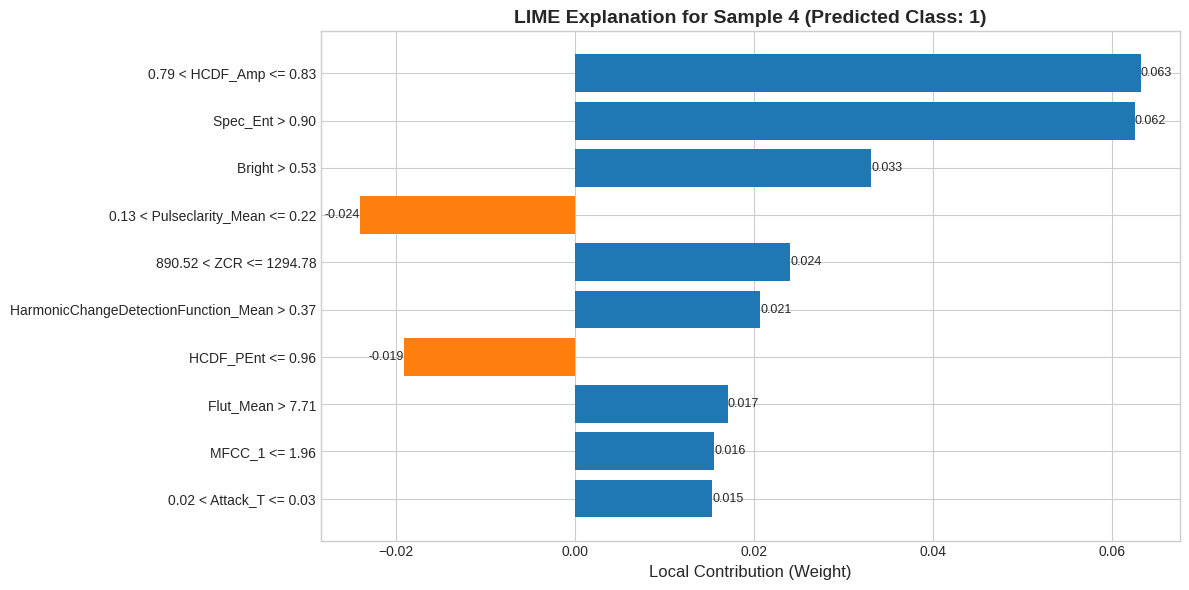

In [ ]:
# 4-1. LIME Explainer 정의
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns.tolist(),
    class_names=[str(c) for c in np.unique(y)],
    mode='classification',
    random_state=42
)

# 4-2. 분석할 샘플 선택
sample_index = 4
sample_to_explain = X_test.iloc[sample_index].values
true_class = y_test.iloc[sample_index]

print(f"\n✅ 분석 샘플 인덱스: {sample_index}")
print(f"   실제 클래스(정답): {true_class}")

model_prediction_proba = model.predict_proba(sample_to_explain.reshape(1, -1))[0]
predicted_class_by_model = np.argmax(model_prediction_proba)
predicted_class_display = str(predicted_class_by_model)

print(f"   모델의 예측 확률: {model_prediction_proba}")
print(f"   모델이 예측한 클래스: {predicted_class_by_model}")


# 4-3. LIME 설명 생성
explanation = explainer.explain_instance(
    data_row=sample_to_explain,
    predict_fn=model.predict_proba,
    num_features=10,
    num_samples=5000
)

# --- 5. LIME 설명 시각화 (Matplotlib으로 약어 적용) ---

def visualize_lime_with_abbreviations(explanation, feature_map, title):
    """
    LIME explanation 객체의 as_list() 결과를 Matplotlib으로 시각화하며
    변수명을 feature_map에 따라 약어로 대체합니다.
    """
    # 모델이 예측한 클래스(top_labels[0])에 대한 설명을 가져옵니다.
    # as_list()는 기본적으로 top_labels[0]에 대한 설명을 반환합니다.
    lime_list = explanation.as_list()

    # 1. 변수명 약어 적용
    updated_lime_list = []

    # feature_map의 키를 길이가 긴 순서대로 정렬하여,
    # 짧은 변수명이 긴 변수명의 일부일 때 발생하는 오매핑을 방지합니다.
    sorted_original_names = sorted(feature_map.keys(), key=len, reverse=True)

    for feature_string, weight in lime_list:
        new_feature_string = feature_string

        # 정렬된 원본 이름 목록을 순회하며 조건 문자열 내에서 대체합니다.
        for original_name in sorted_original_names:
            if original_name in feature_string:
                abbreviation = feature_map[original_name]
                new_feature_string = feature_string.replace(original_name, abbreviation)
                break

        updated_lime_list.append((new_feature_string, weight))

    # 2. 시각화 데이터 준비
    # 변수명이 긴 경우 그래프에 잘 표시되도록 순서를 반전합니다.
    features = [item[0] for item in updated_lime_list]
    weights = np.array([item[1] for item in updated_lime_list])

    # 3. Matplotlib 시각화
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(12, 6))

    # 양수(긍정적 영향)는 초록색, 음수(부정적 영향)는 빨간색으로 표시
    colors = ['#1f77b4' if w > 0 else '#ff7f0e' for w in weights] # Blue/Orange 사용
    y_pos = np.arange(len(features))

    # 수평 막대 그래프 그리기 (가장 중요한 변수가 위에 오도록 y축 반전)
    ax.barh(y_pos, weights, color=colors)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(features, fontsize=10)

    # X축 및 제목 설정
    ax.set_xlabel("Local Contribution (Weight)", fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')

    # 막대 내 값 표시
    for i, w in enumerate(weights):
        ax.text(w, i, f'{w:.3f}', ha='right' if w < 0 else 'left', va='center', fontsize=9)

    # 가장 중요한 변수가 맨 위로 오도록 y축 반전
    ax.invert_yaxis()

    # 그래프 외곽선 및 레이아웃 조정
    plt.tight_layout()
    plt.savefig('LIME.png', dpi = 3000)
    plt.show()

# 시각화 실행
title = f"LIME Explanation for Sample {sample_index} (Predicted Class: {predicted_class_display})"
visualize_lime_with_abbreviations(explanation, column_rename_map, title)

## Interaction Heatmap

🎯 분석 샘플 index=4, 예측 클래스=1


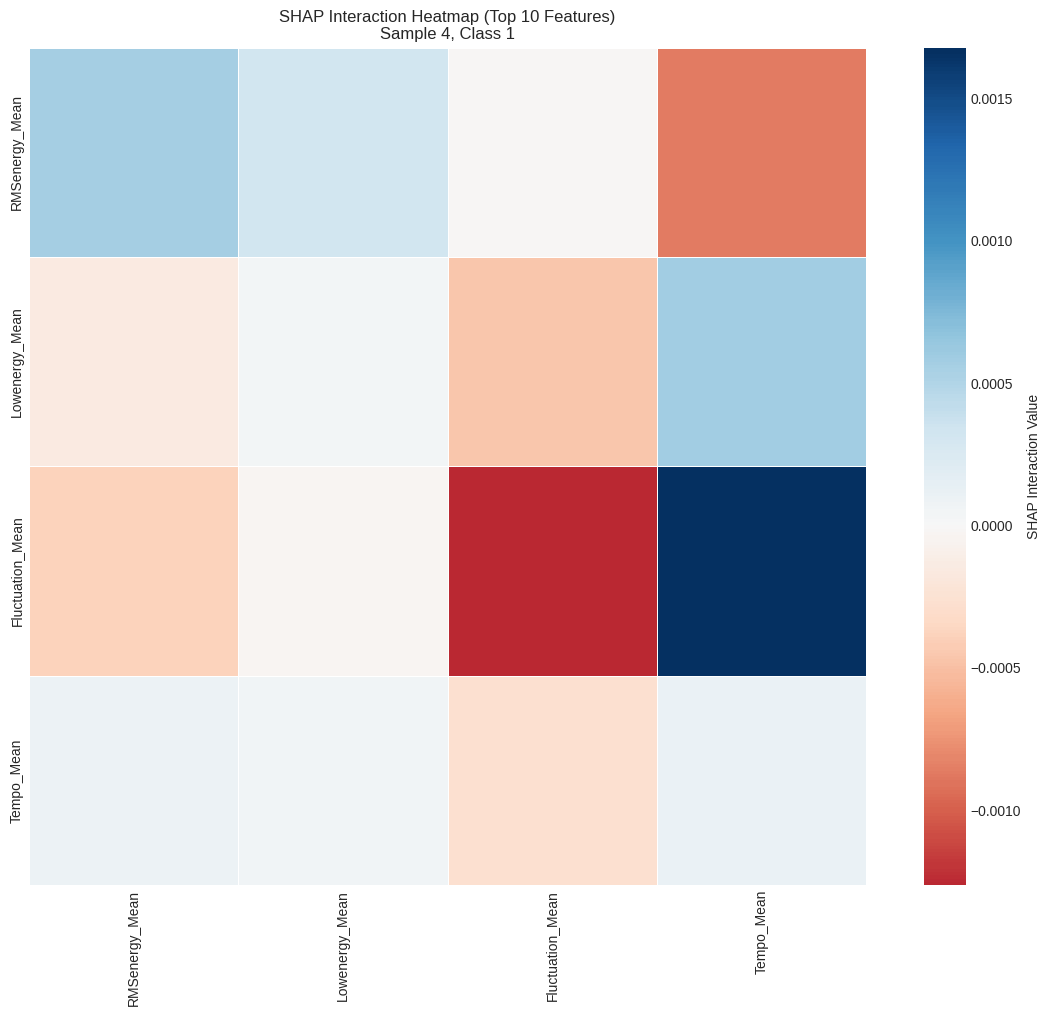

In [ ]:
y = df['Class']
X = df.drop('Class', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

explainer = shap.TreeExplainer(model)
# Note: For multi-class classification, shap_values will be a list of arrays, one for each class.
# We will use shap_interaction_values directly as it's used later in the original code.
shap_interaction_values = explainer.shap_interaction_values(X_test)


# --------------------------------------------------------------
# 4-1. 분석할 클래스/샘플 선택
# --------------------------------------------------------------

preds = model.predict(X_test)
pred_labels = np.argmax(preds, axis=1) if preds.ndim > 1 else preds

target_class = 1
sample_index = 4

print(f"🎯 분석 샘플 index={sample_index}, 예측 클래스={target_class}")

# --------------------------------------------------------------
# 2) 해당 샘플의 SHAP interaction matrix
# --------------------------------------------------------------
interaction_matrix = shap_interaction_values[target_class][sample_index]

# --------------------------------------------------------------
# 3) Top N 영향력 큰 feature만 선택
# --------------------------------------------------------------
N = 10  # 원하는 수로 조절 가능 (추천: 10~15)

# 각 feature의 중요도 = 대각선 값(|self-interaction|)
feature_importance = np.abs(np.diag(interaction_matrix))

# Top N feature index 선정
top_idx = np.argsort(feature_importance)[-N:]

# 작은 index → 큰 index 순으로 정렬
top_idx = top_idx[np.argsort(top_idx)]

# 축소된 interaction matrix
reduced_matrix = interaction_matrix[np.ix_(top_idx, top_idx)]

# 선택된 feature 이름
feature_names = X_test.columns[top_idx].tolist()

# --------------------------------------------------------------
# 4) 히트맵 생성
# --------------------------------------------------------------
plt.figure(figsize=(12, 10))
sns.heatmap(
    reduced_matrix,
    xticklabels=feature_names,
    yticklabels=feature_names,
    cmap="RdBu",
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={'label': 'SHAP Interaction Value'}
)

plt.title(f"SHAP Interaction Heatmap (Top {N} Features)\nSample {sample_index}, Class {target_class}")
plt.xticks(rotation=90)
plt.tight_layout()

plt.savefig('shap_interaction_heatmap_plot.png', dpi =1000)
plt.show()